## RIPE Atlas Data Preparation for Latency Privacy Study

This notebook contains code for downloading anchoring traceroute and ping measurements from RIPE Atlas, and dumping them into an HDF5 datastore for later analysis.

The output consists of three dataframes:

- `rtt_df` contains the following columns:
  - `time`: timestamp of measurement sample
  - `pid`: probe ID
  - `aid`: anchor ID
  - `af`: address family (4 or 6)
  - `proto`: protocol used ("ICMP_PING" or "ICMP_TR" for now)
  - `hopcount`: total count of hops in measurement (0 = ping)
  - `hop`: hop of this measurement (for n-k traceroute)
  - `rtt`: round trip time in microseconds

- `probe_df` contains the following columns:
  - `pid`: probe ID
  - `version`: probe software version (-1 = anchor, 0 = unknown)
  - `nat`: true if probe NATted
  - `ip4`: IPv4 address
  - `ip6`: IPv6 address
  - `asn4`: IPv4 BGP ASN
  - `asn6`: IPv6 BGP ASN
  - `cc`: country code (two-letter 3166)
  - `lon`: longitude 
  - `lat`: latitude

- `anchor_df` contains the following columns:
  - `aid`: anchor ID
  - `name`: anchor name, i.e. FQDN without .anchors.atlas.ripe.net 
  - `pid`: probe ID of colocated probe
  - `ip4`: IPv4 address
  - `ip6`: IPv6 address
  - `asn4`: IPv4 BGP ASN
  - `asn6`: IPv6 BGP ASN
  - `cc`: country code (two-letter 3166)
  - `lon`: longitude 
  - `lat`: latitude


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser as dp
import requests
import json
import os.path

from collections import namedtuple

import warnings
warnings.filterwarnings("ignore") 

### Configuration

Fill in configuration values here, the run all cells in the notebook to produce an HDF5 file to use in subsequent analysis notebooks.

In [2]:
# Local path to cache Atlas measurement data in
ATLAS_CACHE_PATH="atlas_cache_20171002"

# Filename for HDF5 datastore
STORE_PATH="atlas_20171002.hdf5"

# Directory for plots
PLOT_PATH="../plots"

# Start and end time for Atlas measurement retrieval
START_TIME = int(dp.parse("2017-10-02T00:00:00Z").timestamp())
STOP_TIME = int(dp.parse("2017-10-03T00:00:00Z").timestamp())

# Names of anchors we'd like to study
ANCHOR_NAMES_WE_LIKE = [
    "ar-bue-as4270",   # Buenos Aires, Argentina
    "at-vie-as1120",   # Vienna, Austria
    "au-mel-as38796",  # Melbourne, Austraila
    "au-bne-as4608-2", # Brisbane, Australia
    "bd-dac-as24122",  # Dacca, Bangladesh
    "bf-oua-as37577",  # Ouagadougou, Burkina Faso
    "bg-sof-as8866",   # Sofia, Bulgaria
    "br-sao-as22548",  # Sao Paulo, Brasil
    "ca-mtr-as852",    # Montreal, Canada
    "ca-wnp-as18451",  # Winnepeg, Canada
    "ch-gtg-as20612",  # Glattbrug, Switzerland
    "ch-zrh-as559",    # Zurich, Switzerland
    "cz-brq-as197451", # Brno, Czechia
    "de-fra-as8763",   # Frankfurt, Germany
    "de-ham-as201709", # Hamburg, Germany
    "de-muc-as5539",   # Munich, Germany
    "ee-tll-as51349",  # Talinn, Estonia
    "es-bcn-as13041",  # Barcelona, Spain
    "fr-par-as1307",   # Paris, France
    "gr-ath-as5408",   # Athens, Greece
    "hk-hkg-as43996",  # Hong Kong SAR, China
    "hu-bud-as12303",  # Budapest, Hungary
    "id-jkt-as10208",  # Jakarta, Indonesia
    "ie-dub-as1213",   # Dublin, Ireland
    "in-bom-as33480",  # Mumbai, India
    "it-trn-as12779",  # Turin, Italy
    "jp-tyo-as2500",   # Tokyo, Japan
    "ke-nbo-as37578",  # Nairobi, Kenya
    "kz-ala-as21299",  # Almaty, Kazakhstan
    "nl-ams-as3333",   # Amsterdam, Netherlands
    "nl-haa-as201682", # Haarlen, Netherlands
    "nz-wlg-as9834",   # Wellington, New Zealand
    "qa-doh-as8781",   # Doha, Qatar
    "ru-mow-as15835",  # Moscow, Russia
    "se-sto-as8674",   # Stockholm, Sweden
    "uk-lon-as5607",   # London, England
    "us-dal-as2914",   # Dallas, USA
    "us-den-as7922",   # Denver, USA
    "us-mia-as33280",  # Miami, USA
    "us-sjc-as22300",  # San Jose, USA
]

# Protocols to extract latency information from
PROTOCOLS_WE_LIKE = [
    "ICMP_TR",      # Traceroute
    #"ICMP_PING",   # Ping
    #"TCP_HTTP"     # HTTP
]

In [3]:
len(ANCHOR_NAMES_WE_LIKE)

40

## Code

No user-serviceable parts inside. :)

### Probe metadata

In [4]:
# Extract probe information from files
AtlasProbe = namedtuple("AtlasProbe",
           ("pid", "version", "nat", "ip4", "ip6", "asn4", "asn6", "cc", "lon", "lat"))

def extract_atlas_probe(pobj):
    
    if "address_v4" in pobj and pobj['address_v4'] is not None:
        ip4 = pobj["address_v4"]
    elif "prefix_v4" in pobj:
        ip4 = pobj["prefix_v4"]
    else:
        ip4 = None

    if "address_v6" in pobj and pobj['address_v6'] is not None:
        ip6 = pobj["address_v6"]
    elif "prefix_v4" in pobj:
        ip6 = pobj["prefix_v6"]
    else:
        ip6 = None

    if "asn_v4" in pobj:
        asn4 = pobj["asn_v4"]
    else:
        asn4 = None

    if "asn_v6" in pobj:
        asn6 = pobj["asn_v6"]
    else:
        asn6 = None

    if "tags" in pobj:
        if len(pobj['tags']) > 0 and isinstance(pobj['tags'][0], dict):
            alltags = [tag['slug'] for tag in pobj['tags']]
        else:
            alltags = pobj['tags']

        if "system-v1" in alltags:
            version = 1
        elif "system-v2" in alltags:
            version = 2
        elif "system-v3" in alltags:
            version = 3
        elif "system-anchor" in alltags:
            version = -1
        else:
            version = 0 # unknown version - never connected?

        nat = "nat" in alltags
    else:
        version = None
        nat = None
        
    # Short circuit: never connected means don't load
    if "status" in pobj and pobj['status'] == 0:
        version = 0
    
    if "geometry" in pobj and "coordinates" in pobj['geometry']:
        (lon, lat) = pobj['geometry']['coordinates']
    elif "longitude" in pobj and "latitude" in pobj:
        lon = pobj['longitude']
        lat = pobj['latitude']
    else:
        lon = None
        lat = None

    return AtlasProbe(pobj["id"], version, nat, ip4, ip6, asn4, asn6,
                      pobj["country_code"], lon, lat)

def probe_dataframe_from_file(filename):
    data = []
    
    # make a giant array
    with open(filename) as stream:
        all_probes = json.loads(stream.read())
        for pobj in all_probes["objects"]:
            data.append(extract_atlas_probe(pobj))

    # create a dataframe from it
    df = pd.DataFrame(data, columns=AtlasProbe._fields)
    
    # indexed by probe ID
    df.index = df['pid']
    del(df['pid'])
    
    # and return it
    return df

In [5]:
! curl http://ftp.ripe.net/ripe/atlas/probes/archive/meta-latest | bunzip2 > all_probes.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  887k  100  887k    0     0  1177k      0 --:--:-- --:--:-- --:--:-- 1176k


In [6]:
probe_df = probe_dataframe_from_file("all_probes.json")

### Anchor metadata

In [7]:
# Extract anchor information from API
AtlasAnchor = namedtuple("AtlasAnchor",
           ("aid", "name", "pid", "ip4", "ip6", "asn4", "asn6", "cc", "lon", "lat"))

def extract_atlas_anchor(aobj):
    
    if "id" in aobj:
        aid = int(aobj["id"])
    else:
        aid = None

    if "fqdn" in aobj:
        name = aobj["fqdn"]
    else:
        name = None
    
    if name is not None and name.endswith(".anchors.atlas.ripe.net"):
        name = name[:-23]
        
    if "probe" in aobj:
        pid = int(aobj["probe"])
    else:
        pid = None
    
    if "ip_v4" in aobj:
        ip4 = aobj["ip_v4"]
    else:
        ip4 = None
    
    if "ip_v6" in aobj:
        ip6 = aobj["ip_v6"]
    else:
        ip6 = None

    if "as_v4" in aobj and aobj['as_v4'] is not None:
        asn4 = int(aobj["as_v4"])
    else:
        asn4 = None

    if "as_v6" in aobj and aobj['as_v6'] is not None:
        asn6 = int(aobj["as_v6"])
    else:
        asn6 = None
        
    if "country" in aobj:
        cc = aobj['country']
    else:
        cc = None
    
    if "geometry" in aobj and "coordinates" in aobj['geometry']:
        (lon, lat) = aobj['geometry']['coordinates']
    elif "longitude" in aobj and "latitude" in aobj:
        lon = aobj['longitude']
        lat = aobj['latitude']
    else:
        lon = None
        lat = None

    return AtlasAnchor(aid, name, pid, ip4, ip6, asn4, asn6, cc, lon, lat)

def anchor_dataframe_from_v2api():
    data = []
    url = "https://atlas.ripe.net/api/v2/anchors/"

    # iterate over API pagination
    while url is not None:
        res = requests.get(url)
        if not res.ok:
            raise RuntimeError("Atlas probe API request failed: "+repr(res.json()))

        api_content = json.loads(res.content.decode("utf-8"))
        url = api_content['next']
        for aobj in api_content["results"]:
            data.append(extract_atlas_anchor(aobj))
            
    # create a dataframe from it
    df = pd.DataFrame(data, columns=AtlasAnchor._fields)
    
    # indexed by probe ID
    df.index = df['aid']
    del(df['aid'])
    
    # and return it
    return df

In [8]:
anchor_df = anchor_dataframe_from_v2api()

### Anchoring measurement metadata

In [9]:
AnchoringMetadata = namedtuple("AnchoringMetadata", ("aid", "msm", "af", "proto", "start", "stop", "probe_ct"))

def anchoring_measurements_from_v2api(how_many = None):
    data = []
    url = "https://atlas.ripe.net/api/v2/anchor-measurements/?include=measurement"

    # iterate over API pagination
    while url is not None:
        res = requests.get(url)
        if not res.ok:
            raise RuntimeError("Atlas probe API request failed: "+repr(res.json()))

        api_content = json.loads(res.content.decode("utf-8"))
        url = api_content['next']
        for mobj in api_content["results"]:
            try:
                aid = int(mobj["target"].strip("/").split("/")[-1])
                typ = mobj["type"]
                msm = int(mobj["measurement"]["id"])
                af = int(mobj["measurement"]["af"])
                if typ == "traceroute":
                    if "protocol" in mobj["measurement"]:
                        proto = mobj["measurement"]["protocol"] + "_TR"
                    else:
                        proto = "ICMP_TR"
                elif typ == "ping":
                    proto = "ICMP_PING"
                elif typ == "http":
                    proto = "TCP_HTTP"
                else:
                    proto = None
                start = mobj["measurement"]["start_time"]
                stop = mobj["measurement"]["stop_time"]
                probe_ct = mobj["measurement"]["participant_count"]
            except Exception:
                continue
                
            data.append(AnchoringMetadata(aid, msm, af, proto, start, stop, probe_ct))
        
        if how_many is not None and len(data) >= how_many:
            break
            
    # create a dataframe from it
    df = pd.DataFrame(data, columns=AnchoringMetadata._fields)
    
    # indexed by MSM ID
    df.index = df['msm']
    del(df['msm'])
    
    # and return it
    return df

In [ ]:
amsm_df = anchoring_measurements_from_v2api()

In [ ]:
with pd.HDFStore(STORE_PATH) as store:
    store['amsm_df'] = amsm_df

In [10]:
with pd.HDFStore(STORE_PATH) as store:
     amsm_df = store['amsm_df']

### MSM ID extraction

In [11]:
# Turn anchor names into anchor IDs
aid_by_name = anchor_df.loc[:,('name',)]
aid_by_name['aid'] = aid_by_name.index
aid_by_name.index = aid_by_name['name']
del aid_by_name['name']
ANCHORS_WE_LIKE = [aid_by_name.loc[aname]['aid'] for aname in ANCHOR_NAMES_WE_LIKE]

# turn anchor IDs and protocols into MSMs
amsm2_df = amsm_df[amsm_df['aid'].isin(ANCHORS_WE_LIKE)]
amsm3_df = amsm2_df[amsm2_df['proto'].isin(PROTOCOLS_WE_LIKE)]
MSMS_WE_LIKE = amsm3_df.index.values
                    
amsm2_df = None
amsm3_df = None

In [12]:
MSMS_WE_LIKE

array([1026363, 1026365, 1026391, 1026393, 1026399, 1026401, 1042255,
       1042257, 1043286, 1043288, 1404333, 1404335, 1423186, 1423188,
       1437284, 1437286, 1446417, 1446419, 1583040, 1583042, 1589862,
       1589864, 1591156, 1591158, 1664873, 1664875, 1665836, 1665838,
       1668851, 1668853, 1768005, 1768007, 1769991, 1769993, 1790232,
       1790234, 1804069, 1804071, 1849605, 1849607, 1875035, 1875037,
       1898895, 1898897, 1990233, 1990235, 2055768, 2055770, 2096533,
       2096536, 2395060, 2395062, 2398550, 2398552, 2417650, 2417652,
       2456804, 2456806, 3295749, 3295763, 3315653, 3315656, 3614641,
       3614644, 3622418, 3622421, 4464317, 4464320, 6931429, 6931432,
       6969364, 6969367, 7861646, 7861649, 7970886, 7970889, 8434915,
       8434918, 9180598, 9180601, 9180618, 9180621, 9180638, 9180641,
       9180652, 9180655, 9180666, 9180669, 9180704, 9180707, 9180711,
       9180714, 9180724, 9180727, 9180739, 9180742, 9180751, 9180754,
       9180766, 9180

### RTT sample dataframe

In [13]:
# Atlas Latency... something? Raw sample of latency between a source and destination at a given point in time
Alp = namedtuple("Alp", ("msm","time","af","proto","hopcount","pid","sip","dip","rtt"))

RTT_NONE = 0.0

def gen_alp(msm_ary):
    """
    Generator function yielding Alp instances for latency samples from an 
    array containing all results in an MSM downloaded from Atlas.
    """
    for a_res in msm_ary:
        ### for ping, extract each latency sample into its own row
        if a_res['type'] == 'ping':
            if "rcvd" in a_res:
                for x in a_res["result"]:
                    rtt = None
                    try: 
                        rtt = float(x)
                    except:
                        try:
                            rtt = float(x['rtt'])
                        except:
                            pass
                    if rtt:
                        yield Alp(a_res['msm_id'],
                                  int(a_res['timestamp']), 
                                  a_res['af'], 
                                  a_res['proto'] + '_PING', 
                                  0,
                                  a_res['prb_id'], 
                                  a_res['src_addr'], 
                                  a_res['dst_addr'], 
                                  int(rtt * 1000))
        
        # For traceroute, extract each of the latency samples at the last hop into its own row
        # FIXME: hacking this to get last N hops, too 
        elif a_res['type'] == 'traceroute':
            if ('result' in a_res) and ('result' in a_res['result'][-1]):
                for h_res in a_res['result'][-1]['result']:
                    if ('from' in h_res) and ('rtt' in h_res) and (h_res['from'] == a_res['dst_addr']):
                        yield Alp(a_res['msm_id'],
                                  int(a_res['timestamp']), 
                                  a_res['af'], 
                                  a_res['proto'] + '_TR', 
                                  a_res['result'][-1]['hop'],
                                  a_res['prb_id'], 
                                  a_res['src_addr'], 
                                  a_res['dst_addr'], 
                                  h_res['rtt'])

        # For HTTP, return each subresult as a separate RTT sample
        elif a_res['type'] == 'http':
            for r_res in a_res['result']:
                if ('res' in r_res) and (r_res['res'] < 400):
                    yield Alp(a_res['timestamp'], r_res['af'], 'TCP_HTTP', 
                              a_res['prb_id'], r_res['src_addr'], r_res['dst_addr'], r_res['rt'])


def alps_for_msm_id(msm_id, cachedir=None, start=None, stop=None):
    """
    Given an MSM ID, fetch results from the cache or from the RIPE Atlas API.
    Yield each separate result according to the generation function.
    """
    url = "https://atlas.ripe.net/api/v2/measurements/%u/results/" % (msm_id,)

    params = {"format": "json"}
    if start is not None and stop is not None:
        params["start"] = str(start)
        params["stop"] = str(stop)
    
    if cachedir and os.path.isdir(cachedir):
        filepath = os.path.join(cachedir, "measurement", "%u.json" % (msm_id,))

        # download if not present
        if not os.path.isfile(filepath):
            with open(filepath, mode="wb") as file:
                print("Cache miss, retrieving "+url)
                res = requests.get(url, params=params)

                if not res.ok:
                    raise "Atlas measurement API request failed: "+repr(res.json())
                
                file.write(res.content)

        # then read from cache
        with open(filepath) as stream:
            yield from gen_alp(json.loads(stream.read()))

    else:
        # just read from the net
        print("Retrieving "+url+" uncached")
        res = requests.get(url, params=params)
        yield from gen_alp(json.loads(res.content.decode("utf-8")))

def alp_df_gen(msm_ids, cachedir=None, start=None, stop=None):
    for msm_id in msm_ids:
        yield from alps_for_msm_id(msm_id, cachedir=cachedir, start=start, stop=stop)

In [13]:
!mkdir -p $ATLAS_CACHE_PATH/measurement

In [17]:
rtt_df = pd.DataFrame(alp_df_gen(MSMS_WE_LIKE, cachedir=ATLAS_CACHE_PATH, start=START_TIME, stop=STOP_TIME))

Now join the anchor ID to the RTT data frame, and clean up for export (anchor ID and time columns)

In [18]:
aid_by_ip4 = anchor_df.loc[:,('ip4',)]
aid_by_ip4['aid'] = aid_by_ip4.index
aid_by_ip4.index = aid_by_ip4['ip4']
del aid_by_ip4['ip4']

aid_by_ip6 = anchor_df.loc[:,('ip6',)]
aid_by_ip6['aid'] = aid_by_ip6.index
aid_by_ip6.index = aid_by_ip6['ip6']
del aid_by_ip6['ip6']

rtt_df = pd.concat((rtt_df[rtt_df['af']==4].join(aid_by_ip4, on="dip"), 
                    rtt_df[rtt_df['af']==6].join(aid_by_ip6, on="dip"))).dropna()

In [19]:
rtt_df['time'] = pd.to_datetime(rtt_df['time'] * 1e9)
rtt_df['aid'] = pd.to_numeric(rtt_df['aid'], downcast='unsigned')

### RTT minimum dataframe

In [20]:
min_df = pd.DataFrame({'minrtt': rtt_df.groupby(['aid','pid'])['rtt'].min(),
                       'rttstd': rtt_df.groupby(['aid','pid'])['rtt'].std(), 
                             'minhops': rtt_df.groupby(['aid','pid'])['hopcount'].min(),
                             'n':      rtt_df.groupby(['aid','pid'])['rtt'].count()})
loc_by_aid = anchor_df.loc[:,('lon','lat')]
loc_by_aid.columns = ['alon','alat']
loc_by_pid = probe_df.loc[:,('lon','lat')]
loc_by_pid.columns = ['plon','plat']
min_df = loc_by_pid.join(loc_by_aid.join(min_df, how="inner"), how="inner")

### Dump dataframes to HDF

In [24]:
with pd.HDFStore(STORE_PATH) as store:
    store["rtt_df"] = rtt_df
    store["min_df"] = min_df
    store["anchor_df"] = anchor_df
    store["probe_df"] = probe_df

## Dataset Description

plot heatmap of probes and anchors

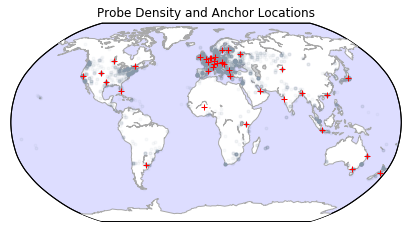

In [22]:
from mpl_toolkits.basemap import Basemap

# Plot all anchors and probes on the world map
aloc_df = min_df.groupby(level=[0]).first().loc[:,['alon','alat']]
ploc_df = min_df.groupby(level=[1]).first().loc[:,['plon','plat']]

plt.figure(figsize=(7,5))
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines(color="darkgrey")
m.fillcontinents(color='white',lake_color='lightgrey')
m.drawmapboundary(fill_color='#ddddff')
for pid, point in ploc_df.iterrows():
    x, y = m(point['plon'], point['plat'])
    plt.plot(x,y,".",alpha=0.05,color="#8899aa")
for aid, point in aloc_df.iterrows():
    x, y = m(point['alon'], point['alat'])
    plt.plot(x,y,"r+")
plt.title("Probe Density and Anchor Locations")
plt.savefig(os.path.join(PLOT_PATH,"atlasmap.pdf"))
plt.show()


In [23]:
min_df

plon     plat      alon       alat  minhops   minrtt    n  \
aid  pid                                                                    
4    43       4.8595  45.7285  7.660600  45.091300       13   26.455  287   
     59       6.7795  49.3315  7.660600  45.091300       14   34.686  288   
     60       8.7105  46.2475  7.660600  45.091300        9   19.440  573   
     82       9.8115  52.3885  7.660600  45.091300        8   31.956  288   
     114     19.1375  48.7395  7.660600  45.091300       13   46.269  287   
     142      9.0995  45.4785  7.660600  45.091300        5    4.371  288   
     144     13.3195  41.6195  7.660600  45.091300        6   15.500  288   
     148     14.4695  50.0815  7.660600  45.091300        6   23.711  288   
     241     37.6195  55.7575  7.660600  45.091300       12   49.122  285   
     242     18.4895 -33.9815  7.660600  45.091300       11  181.991  288   
     249     12.4895  41.8915  7.660600  45.091300        7   13.598  288   
     274     11.0805  49.4495  7.660600  45.091300       11   18.219  288   
     282     19.0615  47.5685  7.660600  45.091300       12   41.604  288   
     331   -117.2315  32.8775  7.660600  45.091300       27  181.265  288   
     341     -3.9805  40.5975  7.660600  45.091300       11   36.372  285   
     357     16.4095  48.2705  7.660600  45.091300        8   25.969  288   
     373     12.2605  57.7685  7.660600  45.091300       14   37.987  288   
     376     12.5205  41.9105  7.660600  45.091300       16   15.970  288   
     384     10.7715  59.9495  7.660600  45.091300       18   43.985  288   
     392     23.8015  38.0485  7.660600  45.091300       10   87.374  285   
     407      8.6675  50.1105  7.660600  45.091300        7   14.199  288   
     452      7.5795  47.5485  7.660600  45.091300        6   18.445  288   
     461     11.6005  48.1875  7.660600  45.091300        9   20.408  288   
     567     10.1805  36.8205  7.660600  45.091300        6   35.598  288   
     617     12.7075  42.9605  7.660600  45.091300        6   17.890  288   
     619     15.4275  46.7515  7.660600  45.091300        8   34.429  288   
     626     37.5685  54.1805  7.660600  45.091300        9   55.175  288   
     632     -3.9815  40.5985  7.660600  45.091300       11   50.304  179   
     668     35.3705  52.3315  7.660600  45.091300       11   64.567  287   
     681     33.1115  48.6675  7.660600  45.091300        7   51.057  576   
...              ...      ...       ...        ...      ...      ...  ...   
1038 33829   25.0985  60.3815 -1.514821  12.366974       14  181.088  279   
     33832    3.0385  50.5785 -1.514821  12.366974       14  150.209  276   
     33835    4.7085  50.8695 -1.514821  12.366974       12  170.712  277   
     33849   35.1695  31.7915 -1.514821  12.366974       12  204.518  281   
     33852    8.5395  47.3785 -1.514821  12.366974       15  161.285  282   
     33853    2.2895  48.6885 -1.514821  12.366974        9  154.978  281   
     33854   16.3395  48.2295 -1.514821  12.366974       14  219.776  277   
     33855   30.5095  50.4495 -1.514821  12.366974       11  176.198  280   
     33857  106.8295  -6.2295 -1.514821  12.366974       10  420.720  280   
     33859  106.9095  47.8915 -1.514821  12.366974       16  300.018  278   
     33875    9.2005  48.7895 -1.514821  12.366974       16  155.007  281   
     33888    1.4515  43.6315 -1.514821  12.366974       11  119.628  282   
     33896   13.4415  52.6605 -1.514821  12.366974       17  149.739  278   
     33907    5.7575  49.5205 -1.514821  12.366974       11  181.719  278   
     33917   -0.6925  45.3905 -1.514821  12.366974       13  151.045  282   
     33918    8.7075  47.3515 -1.514821  12.366974       14  161.934  280   
     33921   14.4685  50.1175 -1.514821  12.366974       14  178.421  282   
     33923    4.8685  45.7485 -1.514821  12.366974       13  178.337  283   
     33930   -6.0015  37.3975 -1.514821  12.366974       12  215.420  282   
     33937  